# Planning directly with the VLM

The goal is to replicate a closed-loop planning system using the VLM similar to [ViLa](https://arxiv.org/pdf/2311.17842) to use as a baseline for our benchmark.

The VLM will receive a description of the environment in the prompt, a list of previous actions and a note saying if they failed or not, and will be tasked to generate a new plan to get to the goal. The goal configuration itself will be described in natural language as well (not with an image).

In [1]:
import os
import sys

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/open-world-symbolic-planner


In [2]:
sys.path.append(ROOT)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader

from PIL import Image
import matplotlib.pyplot as plt

from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from viplan.code_helpers import get_logger

In [5]:
DOMAIN_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'domain.pddl')
PROBLEM_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'test_problem_3.pddl')

reader = PDDLReader()
problem = reader.parse_problem(DOMAIN_FILE, PROBLEM_FILE)

In [6]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

[INFO] [15:49:25] GPU rendering: True
[INFO] [15:49:27] Rendered state in 1.95 seconds


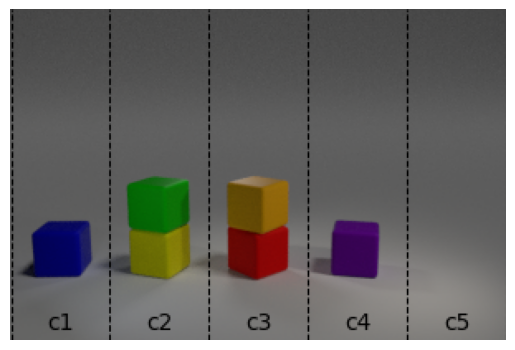

In [7]:
logger = get_logger(log_level='info')
env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1)
plot_image(env.render())

## Goal translation

Now, let's first define a way to translate the goal into natural language using templates. This is an ad-hoc solution for blocksworld, let's focus on this for now.

In [8]:
block_templates = {
    'r': 'red block',
    'g': 'green block',
    'b': 'blue block',
    'y': 'yellow block',
    'o': 'orange block',
    'p': 'purple block',
}


In [9]:
goal_predicates = problem.goals[0] # Assuming there are just a set of "ands" in the goal
assert goal_predicates.is_and()
for goal in goal_predicates.args:
    assert goal.is_fluent_exp(), "Goal structure was not a simple conjunction of fluents"
goal_fluents = goal_predicates.args

blocks = list(problem.objects(problem.user_type('block')))

goal_string = ""

for block in blocks:
    block_fluents = [f for f in goal_fluents if f.args[0].object() == block]
    # print(f"Block {block.name} has {len(block_fluents)} fluents in the goal")
    print(f"Block {block.name} has fluents: {block_fluents}")
    
    goal_string += f"The {block_templates[block.name]}"
    
    for i, block_fluent in enumerate(block_fluents):
        name = block_fluent.fluent().name
        if name == 'incolumn':
            goal_string += f" needs to be in the column with label '{block_fluent.args[1].object().name}'"
        elif name == 'on':
            goal_string += f" needs to be on top of the {block_templates[block_fluent.args[1].object().name]}"
        elif name == 'clear':
            goal_string += f" needs to be the topmost block in its column"
        else:
            raise Exception(f"Unknown fluent {name} in goal")
        goal_string += "," if i < len(block_fluents) - 2 else " and" if i == len(block_fluents) - 2 else ". "
        
    goal_string += "\n"
    
print()
print(goal_string)
        

Block r has fluents: [incolumn(r, c1), clear(r)]
Block g has fluents: [incolumn(g, c5), clear(g)]
Block b has fluents: [incolumn(b, c3), clear(b)]
Block y has fluents: [incolumn(y, c4)]
Block o has fluents: [incolumn(o, c2), clear(o)]
Block p has fluents: [incolumn(p, c4), on(p, y), clear(p)]

The red block needs to be in the column with label 'c1' and needs to be the topmost block in its column. 
The green block needs to be in the column with label 'c5' and needs to be the topmost block in its column. 
The blue block needs to be in the column with label 'c3' and needs to be the topmost block in its column. 
The yellow block needs to be in the column with label 'c4'. 
The orange block needs to be in the column with label 'c2' and needs to be the topmost block in its column. 
The purple block needs to be in the column with label 'c4', needs to be on top of the yellow block and needs to be the topmost block in its column. 



From this, let's construct the prompt:

In [11]:
base_prompt_path = os.path.join(ROOT, 'data', 'prompts', 'planning', 'blocksworld.md')
with open(base_prompt_path, 'r') as f:
    base_prompt = f.read()

base_prompt = base_prompt.replace("{goal_string}", goal_string)
prompt = base_prompt.replace("{previous_actions}", "[]")
print(prompt)

<system> 
You are an expert planning assistant. You will be given an image which represents the current state of the environment you are in, a natural language description of the goal that needs to be achieved and a set of actions that can be performed in the environment. 
Your task is to generate a plan that achieves the goal, in the form of a sequence of actions that need to be executed to reach the goal.
The format of your output should be a JSON object with the following structure:
```json
{
  "plan": [
    {
        "action": action_name,
        "parameters": {
            parameter_name: parameter_value
        }
    },
    ... other actions ...
    ]
}
```

You will also receive feedback of the previously taken actions, with a note showing if they failed or not. If an action failed, think about why that could be and then output a new plan accordingly.
</system>
<user>
## Description of the environment
The environment is about colored blocks and how they relate to each other. In

## VLM planning

In [12]:
import torch

from viplan.models import HuggingFaceVLM
from viplan.code_helpers import get_logger, parse_output

In [13]:
import transformers

torch.manual_seed(1)
transformers.set_seed(1)

In [14]:
logger = get_logger(log_level='info')

model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
# model_name = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
hf_cache_dir = "/scratch/cs/world-models/hf_models"

logger.info(f"Using GPU: {torch.cuda.get_device_name()}." if torch.cuda.is_available() else "Using CPU.")
if torch.cuda.is_available() and 'A100' in torch.cuda.get_device_name() or 'H100' in torch.cuda.get_device_name() or 'H200' in torch.cuda.get_device_name():
    use_flash_attn = True
else:
    use_flash_attn = False
logger.info(f"Use flash attention: {use_flash_attn}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

model = HuggingFaceVLM(model_name, cache_dir=hf_cache_dir, logger=logger, temperature=0, device=device, dtype=dtype, use_flash_attn=use_flash_attn)

[INFO] [15:50:51] Using GPU: NVIDIA A100-SXM4-80GB.
[INFO] [15:50:51] Use flash attention: True
[INFO] [15:50:51] Loading model Qwen/Qwen2.5-VL-7B-Instruct
[INFO] [15:50:51] Trust remote code: False


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] [15:51:14] Model Qwen/Qwen2.5-VL-7B-Instruct loaded on device cuda with torch.bfloat16 precision.


In [15]:
outputs = model.generate(prompts=[prompt], images=[env.render()], return_probs=False)

[INFO] [15:51:16] Rendered state in 1.79 seconds


In [16]:
print(outputs[0])

```json
{
  "plan": [
    {
      "action": "moveblock",
      "parameters": {
        "block": "b",
        "column": "c1"
      }
    },
    {
      "action": "moveblock",
      "parameters": {
        "block": "g",
        "column": "c5"
      }
    },
    {
      "action": "moveblock",
      "parameters": {
        "block": "r",
        "column": "c3"
      }
    },
    {
      "action": "moveblock",
      "parameters": {
        "block": "y",
        "column": "c4"
      }
    },
    {
      "action": "moveblock",
      "parameters": {
        "block": "o",
        "column": "c2"
      }
    },
    {
      "action": "moveblock",
      "parameters": {
        "block": "p",
        "column": "c4"
      }
    }
  ]
}
```


In [17]:
import json

def parse_json_output(output):
    json_start = output.find('{')
    json_end = output.rfind('}')
    vlm_plan = json.loads(output[json_start:json_end + 1])
    return vlm_plan

parse_json_output(outputs[0])['plan']

[{'action': 'moveblock', 'parameters': {'block': 'b', 'column': 'c1'}},
 {'action': 'moveblock', 'parameters': {'block': 'g', 'column': 'c5'}},
 {'action': 'moveblock', 'parameters': {'block': 'r', 'column': 'c3'}},
 {'action': 'moveblock', 'parameters': {'block': 'y', 'column': 'c4'}},
 {'action': 'moveblock', 'parameters': {'block': 'o', 'column': 'c2'}},
 {'action': 'moveblock', 'parameters': {'block': 'p', 'column': 'c4'}}]

In [18]:
def get_plan_action(json_plan):
    first_action = json_plan['plan'][0]
    return env._get_specific_action(block=first_action['parameters']['block'], column=first_action['parameters']['column'], action_name=first_action['action'])

get_plan_action(parse_json_output(outputs[0]))

moveblock(b, c1)

In [19]:
print(env)

[['-' 'G' 'O' '-' '-']
 ['B' 'Y' 'R' 'P' '-']]


In [20]:
success = env.apply_action(get_plan_action(parse_json_output(outputs[0])))
print(success)

[INFO] [15:51:34] Action moveblock(b, c1) is not legal.
False


Ok, the action works but is just illegal. Let's try the full planning loop now.

## Planning loop

In [21]:
def planning_loop(env, model, base_prompt, logger, max_steps=50):
    previous_actions = []

    while not env.goal_reached and max_steps > 0:
        logger.info(f"Step {50 - max_steps + 1}")
        prompt = base_prompt.replace("{previous_actions}", json.dumps(previous_actions))
        logger.info(f"Prompt:\n{prompt}")
        
        outputs = model.generate(prompts=[prompt], images=[env.render()], return_probs=False)
        logger.info("VLM output: " + outputs[0])
        vlm_plan = parse_json_output(outputs[0])
        action = get_plan_action(vlm_plan)
        logger.info(f"First action: {action}")
        logger.info(f"Environment state:\n{env}")

        success = env.apply_action(action)
        previous_actions.append({'action': str(action.action.name), 'parameters': {str(p): str(v) for p, v in zip([p.type for p in action.action.parameters], action.actual_parameters)}, 'failed': not success})
        logger.info(f"Previous actions: {previous_actions}")

        max_steps -= 1
    

In [22]:
planning_loop(env, model, base_prompt, logger)

[INFO] [15:51:34] Step 1
[INFO] [15:51:34] Prompt:
<system> 
You are an expert planning assistant. You will be given an image which represents the current state of the environment you are in, a natural language description of the goal that needs to be achieved and a set of actions that can be performed in the environment. 
Your task is to generate a plan that achieves the goal, in the form of a sequence of actions that need to be executed to reach the goal.
The format of your output should be a JSON object with the following structure:
```json
{
  "plan": [
    {
        "action": action_name,
        "parameters": {
            parameter_name: parameter_value
        }
    },
    ... other actions ...
    ]
}
```

You will also receive feedback of the previously taken actions, with a note showing if they failed or not. If an action failed, think about why that could be and then output a new plan accordingly.
</system>
<user>
## Description of the environment
The environment is about c

KeyboardInterrupt: 